# VAE using the reparametrization trick

## Import TensorFlow and enable Eager execution

In [2]:
import json
from collections import namedtuple
import itertools
import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from functional import seq
from pathlib import Path
from functools import reduce

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow_probability as tfp
tfe = tf.contrib.eager
tfc = tf.contrib
tf.enable_eager_execution()
tfe.seterr(inf_or_nan='raise')
tfk = tf.keras
tfkl = tf.keras.layers

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import som_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl, if_last
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings import data as SD
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

W0607 17:09:04.856659 139727811774272 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0607 17:09:04.861337 139727811774272 deprecation_wrapper.py:119] From /home/samuel/SOM-VAE/som_vae/helpers/tensorflow.py:5: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [3]:
jupyter.fix_layout()

## Constants

In [4]:
# all those experiments and data will be used
from som_vae.settings import config
print(f"this is the main experiment, study, and fly id: {config.full_experiment_id()}.\n\nloadable experiments. there is a blacklist below.")
!ls $config.__EXPERIMENT_ROOT__

this is the main experiment, study, and fly id: 180920_aDN_CsCh-001_SG1-Fly2.

loadable experiments. there is a blacklist below.
180918_MDN_CsCh  180919_MDN_CsCh  180920_MDN_CsCh  180921_MDN_PR
180918_MDN_PR	 180919_MDN_PR	  180920_MDN_PR    181220_Rpr_R57C10_GC6s_tdTom
180919_aDN_CsCh  180920_aDN_CsCh  180921_aDN_CsCh
180919_aDN_PR	 180920_aDN_PR	  180921_aDN_PR


In [5]:
# if you want to see the flys as well, or just more information
# !tree -L 2 $config.__EXPERIMENT_ROOT__

In [6]:
config.positional_data(SD.EXPERIMENTS[0]).shape

(7, 899, 38, 2)

In [7]:
_EXPERIMENT_BLACK_LIST_ = ['181220_Rpr_R57C10_GC6s_tdTom'] # all other experiments are used
_FLY_BLACK_LIST_ = ['180920_aDN_PR-Fly2-005_SG1', '180921_aDN_CsCh-Fly6-003_SG1'] # for those flys the angle conversion give odd results,
                                                                                  # and their distributions seem way off compared to the others)


_DATA_TYPE_3D_ANGLE_ = '3d_angle'
_DATA_TYPE_2D_POS_ = '2d_pos'
_SUPPORTED_DATA_TYPES_ = [_DATA_TYPE_3D_ANGLE_, _DATA_TYPE_2D_POS_]

_MODEL_IMPL_TEMPORAL_CONV_ = 'temp_conv'
_MODEL_IMPL_PADD_CONV_ = 'padd_conv'

run_config = {
    'debug': True,                 # general flag for debug mode, triggers all `d_.*`-options.
    'd_zero_data': False,          # overwrite the data with zeroed out data, the overall shape is kept.
    'd_sinoid_data': False, 
    'd_sinoid_cluster_data': True,
    'd_no_compression': False,     # if true, the latent_space will be the same dimension as the input. allowing the model to learn the identity function.
    'use_all_experiments': False,
    'data_type': _DATA_TYPE_3D_ANGLE_, 
    'use_time_series': True,       # triggers time series application, without this the model is only dense layers
    'time_series_length': 42,      # note that this is equal to the minimal wanted receptive field length
    'conv_layer_kernel_size': 2,   # you can set either this or `n_conv_layers` to None, it will be automatically computed. see section `Doc` for an explanation.
    'n_conv_layers': None,         # you can set either this or `conv_layer_kernel_size` to None, it will be automatically computed. see section `Doc` for an explanation.
    'latent_dim': None,               # should be adapted given the input dim
    'batch_size': 100,
    'loss_weight_reconstruction': 1.0, # will be adjusted further down (currently)
    'loss_weight_kl': 0.0,             # will be adjusted further down (currently)
    'dropout_rate': 0.,
    'with_batch_norm': True,
    'model_impl': _MODEL_IMPL_TEMPORAL_CONV_
}

# And now the ... ugly parts begin. -> TODO put this in a class, 

if run_config['use_all_experiments']:
    # takes way too long otherwise
    run_config['batch_size'] = 1000

if not(run_config['data_type'] in _SUPPORTED_DATA_TYPES_):
    raise NotImplementedError(f"This data type is not supported. Must be one of either {_SUPPORTED_DATA_TYPES_}")
    
if run_config['n_conv_layers'] is None:
    run_config['n_conv_layers'] = np.int(np.ceil(np.log2((run_config['time_series_length'] - 1) / (2 * (run_config['conv_layer_kernel_size'] - 1)) + 1)))

if run_config['conv_layer_kernel_size'] is None:
    raise NotImplementedError('ups')
    
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    # goes from 15 * 2 = 30 -> 8
    run_config['latent_dim'] = 8
elif run_config['data_type'] == _DATA_TYPE_3D_ANGLE_:
    # goes from 18 -> 4
    run_config['latent_dim'] = 8
else:
    raise ValueError(f"this data_type is not supported: {run_config['data_type']}")

## Loading of 2d positional data

In [8]:
def experiments_from_root(root=config.__EXPERIMENT_ROOT__):
    return seq(Path(root).iterdir()).flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .map(lambda p: reduce(lambda acc, el: ([*acc[0], acc[1].stem], acc[1].parent), range(3), ([], p)))\
                                    .map(lambda pair: list(reversed(pair[0])))\
                                    .map(lambda ls: SD.Experiment._make([*ls, SD._key_from_list_(ls)]))\
                                    .to_list()

In [9]:
if not run_config['use_all_experiments']:
    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [10]:
# TODO form a wrapper around the used data, experiments (the ids), data, normalisation factor, images, ... a namedtuple should do the trick
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    if run_config['use_all_experiments']:
        all_experiments = [e for e in experiments_from_root() if e.study_id not in _EXPERIMENT_BLACK_LIST_ or config.get_experiment_id(e) in _FLY_BLACK_LIST_]
        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(all_experiments, normalize_data=True)
    else:
        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS, normalize_data=True)

        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

        if len(frames_of_interest) != len(joint_positions):
            warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
            frames_of_interest = np.where(frames_of_interest[:len(joint_positions)])[0]
        
        joint_positions = joint_positions[frames_of_interest[:len(joint_positions)]]
        frames_idx_with_labels = frames_idx_with_labels.iloc[frames_of_interest]
        images_paths_for_experiments =  np.array(images_paths_for_experiments)[frames_of_interest].tolist()

## loading of angle-data

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: There is a bug here. The number of images and number of data points to NOT align.
  


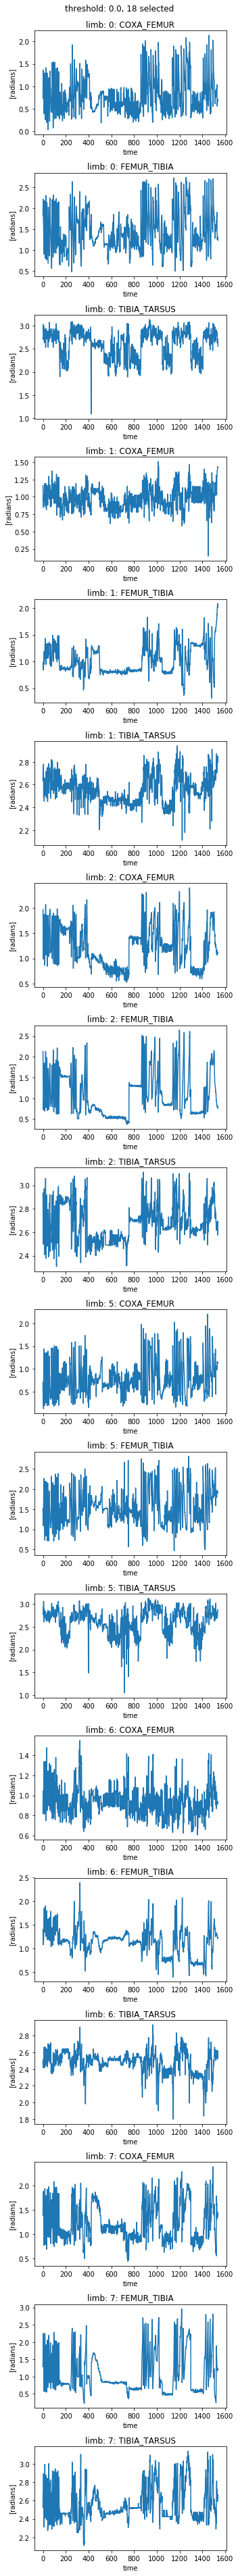

In [11]:
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and not run_config['use_all_experiments']:
    data_angle = np.vstack(seq(settings.data.EXPERIMENTS).map(lambda x: settings.config.positional_data(x, dimensions='3d')))

    #
    # Using man-made selection (from Semigh)
    #
    data_angle_raw = SD.convert_3d_to_angle(data_angle)
    warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
    frames_of_interest = frames_of_interest[:len(data_angle_raw)]
    
    selected_cols = [2,7,12, 19+2, 19+4, 19+12]
    angled_data_columns = SD.get_3d_columns_names(selected_cols)
    # for some odd reason numpy complains with I do data_angle_raw[frames_of_interest, selected_cols]
    #plots.plot_angle_columns(data_angle_raw[:, selected_cols][frames_of_interest], angled_data_columns);
    
    # But not all of this data has information in it (measured by variance),
    # so we use a different selection

    #
    # column selection 
    #
    threshold = 0.
    selected_cols = np.where(np.var(data_angle_raw, axis=0) > threshold)[0]
    
    angled_data_columns = SD.get_3d_columns_names(selected_cols)
    f = plots.plot_angle_columns(data_angle_raw[:, selected_cols][frames_of_interest], angled_data_columns)
    f.suptitle(f"threshold: {threshold}, {len(selected_cols)} selected");
    plt.subplots_adjust(top=0.97)

    # TODO not so sure here, should we really normalize the data?
    joint_positions, normalisation_factors = preprocessing.normalize(data_angle_raw[:, selected_cols][frames_of_interest])

In [12]:
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and run_config['use_all_experiments']:
    all_experiments = [e for e in experiments_from_root() if (e.study_id not in _EXPERIMENT_BLACK_LIST_) and (e.key not in _FLY_BLACK_LIST_)]
    # `per_experiment` is a shitty parameter name, the data is not normalised and return per experiment.
    loading_kwargs = {'dimensions': '3d', 'return_with_experiment_id': True}
    angle_data_raw = [(exp_id, SD.convert_3d_to_angle(d)) for exp_id, d in preprocessing.get_data_and_normalization(all_experiments, **loading_kwargs)]

    # takes for ever to render, if you want to see this, please run it yourself
    #plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

    exp_ids, angle_data  = zip(*angle_data_raw)
    angle_data = np.vstack(angle_data)
    selected_cols = np.where(np.var(angle_data, axis=0) > 0.0)[0]
    joint_positions = angle_data[:, selected_cols]

In [13]:
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_:
    plots.get_3d_columns_names(selected_cols)

In [14]:
# will generate a huge plot and take about 6min to run...
#plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

In [15]:
#all_experiments = experiments_from_root()
#print(len(all_experiments))
#
#pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)
#
#norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
#experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
#norm_pos_data = np.vstack(norm_pos_data)
#
#print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")
#
#norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))
#
##_cs = sns.color_palette(n_colors=len(seen_labels))
##
##fig = plt.figure(figsize=(10, 10))
##_all_frames_ = pd.concat((training_frames, testing_frames))
##
##behaviour_colours = dict(zip(seen_labels, _cs))
##
##for l, c in behaviour_colours.items():
##    _d = X_embedded[_all_frames_['label'] == l]
##    # c=[c] since matplotlib asks for it
##    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
##    
##plt.legend()
##plt.title('simple t-SNE on latent space')
##fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")
#
#_cs = sns.color_palette(n_colors=len(experiment_lengths))
#
#
#used_until = 0
#for i, l in enumerate(experiment_lengths):
#    plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
#    used_until += l

In [16]:
joint_positions.shape

(1538, 18)

# preprocessing

In [17]:
def dummy_data_complex_sine_like(length):
    DummyBehaviour = namedtuple('DummyBehaviour', 'type amplitude fraction frequency')
    _dummy_behaviours_ = [
        ('sinoid', 1., 0.1, 2),
        ('flat', 0, 0.2, 0),
        ('sinoid', 1., 0.2, 3),
        ('sinoid', 1., 0.1, 5),
        ('flat', 1., 0.2, 0),
        ('sinoid', .5, .2, 3)
    ]

    assert np.array(_dummy_behaviours_)[:, 2].astype(np.float).sum() == 1., "I don't know how to split the time duration with the given fractions"

    _dummy_behaviours_ = [DummyBehaviour(*db) for db in _dummy_behaviours_]
    
    cur_idx = 0
    nb_frames = length

    _new_frames_ = np.zeros(nb_frames)

    for db in _dummy_behaviours_:
        cur_idx_end = np.int(nb_frames * db.fraction + cur_idx)
        if db.type == 'sinoid':
            _new_frames_[cur_idx: cur_idx_end] = db.amplitude * np.sin(np.pi * np.linspace(0, 2, cur_idx_end - cur_idx) * db.frequency)
        elif db.type == 'flat':
            for frame in range(cur_idx, cur_idx_end):
                _new_frames_[frame] = db.amplitude

        cur_idx = cur_idx_end
        
    return _new_frames_

In [18]:
# full preprocessing pipeline

def _to_time_series_(x):
    return np.array(list(misc.to_time_series(x, sequence_length=run_config['time_series_length'])))

def _prep_2d_pos_data_(x):
    return x[:,:,:2].reshape(x.shape[0], -1).astype(np.float32)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction (and because ANN train better with normalised data) (which it is not...)
#scaler = MinMaxScaler()
scaler = StandardScaler()

#
# reshapping the data 
#

# TODO bring this in order! (or in better order)

if run_config['use_time_series']:
    # it's the shitty logical combination of these values
    # TODO the scaling should be learned on the training data only, but this is a bit tricky due to how we do the time-sequences
    # TODO right now the training and testing data are just concatenated time-sequences, experiment overlapping. which is bad.
    warnings.warn('this is not proper, fix the bugs here')
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        reshaped_joint_position = scaler.fit_transform(_prep_2d_pos_data_(joint_positions))
    else:
        reshaped_joint_position = scaler.fit_transform(joint_positions)
        
    reshaped_joint_position = _to_time_series_(reshaped_joint_position)
else:
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        # angle data is already flat
        reshaped_joint_position = _prep_2d_pos_data_(joint_positions)
    else:
        reshaped_joint_position = joint_positions

#
# debugging overwrite
#
    
if run_config['debug']:
    if run_config['d_zero_data']:
        # resetting the scaler to make our life easier down below the pipeline
        _dummy_data_ = np.zeros_like(joint_positions)
    elif run_config['d_sinoid_data']:
        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
            _dummy_data_ = np.zeros_like(joint_positions)
            for frame in range(_dummy_data_.shape[0]):
                for joint in range(_dummy_data_.shape[1]):
                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
                
        else:
            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
                                      for x in range(len(joint_positions))] 
                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
    elif run_config['d_sinoid_cluster_data']:
        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
            raise NotImplementedError
        else:
            _dummy_data_ = np.zeros_like(joint_positions)
            for c in range(_dummy_data_.shape[1]):
                _dummy_data_[:, c] = dummy_data_complex_sine_like(_dummy_data_.shape[0])
            
            
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        _dummy_data_ = _prep_2d_pos_data_(_dummy_data_)
        
    if run_config['use_time_series']:
        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
        reshaped_joint_position = _to_time_series_(reshaped_joint_position)
    else:
        reshaped_joint_position = _dummy_data_

#
# split and apply scaler
#

if reshaped_joint_position.shape[0] > 10**5:
    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.9)
else:
    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)

if run_config['use_time_series']:
    data_train = reshaped_joint_position[:n_of_data_points]
    data_test = reshaped_joint_position[n_of_data_points:]
    print('train')
    display.display(pd.DataFrame(data_train[:, -1, :]).describe())
    print('test')
    display.display(pd.DataFrame(data_test[:, -1, :]).describe())
else:
    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
    print('train')
    display.display(pd.DataFrame(data_train).describe())
    print('test')
    display.display(pd.DataFrame(data_test).describe())
    
print(f"shapes for train/test: {data_train.shape}, {data_test.shape}")

train


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: this is not proper, fix the bugs here


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202,-0.100202
std,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074,1.041074
min,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527,-1.938527
25%,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718,-0.716718
50%,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562,-0.322562
75%,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953,1.047953
max,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402


test


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591,0.176591
std,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833,0.883833
min,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161,-1.130161
25%,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267,-0.660267
50%,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981,0.183981
75%,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402
max,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402,1.293402


shapes for train/test: (1047, 42, 18), (450, 42, 18)


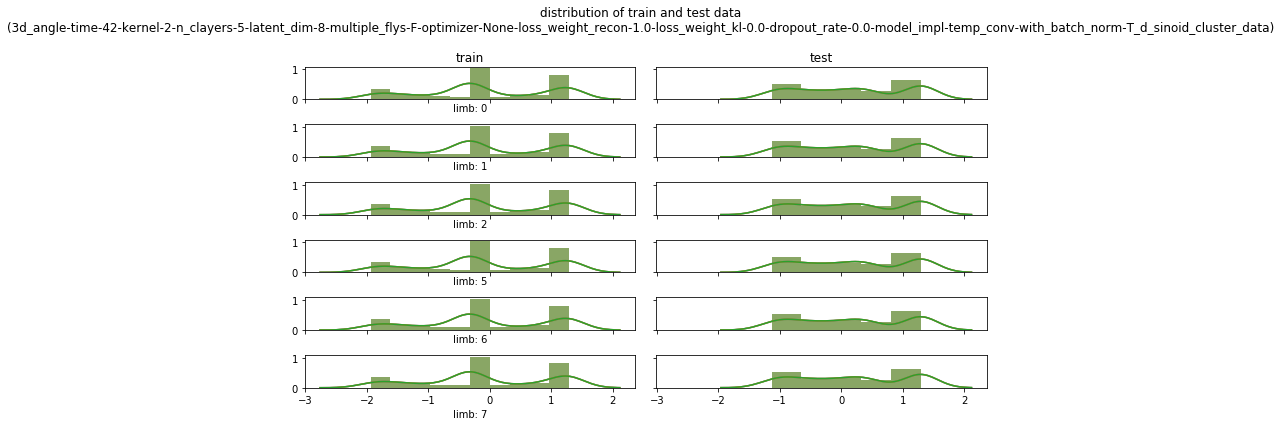

In [19]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
if run_config['use_time_series']:
    _plt_data_idx_ = np.s_[:, -1, :]
else:
    _plt_data_idx_ = np.s_[:]
    
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_:
    fig = plots.plot_3d_angle_data_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], selected_cols, exp_desc=config.config_description(run_config))
else:
    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=config.config_description(run_config))

## Use *tf.data* to create batches and shuffle the dataset

In [20]:
def to_tf_data(X):
    return tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(run_config['batch_size'])

train_dataset = to_tf_data(data_train)
test_dataset = to_tf_data(data_test) 

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

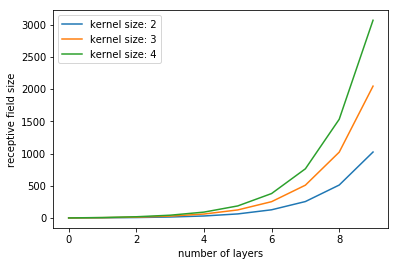

In [21]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## code

In [34]:
class TemporalBlock(tfkl.Layer):
    def __init__(self, filter_size, kernel_size, dilation_rate, dropout=0.2, trainable=True, name=None, dtype=None, activity_regularizer=None, **kwargs):
        """
        In the dilated convolution, the kernel only touches the signal at every lth entry 
        See https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/ (some bugs fixed and code adapted to our use case)
        """
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs)        
        self.dropout = dropout
        self.filter_size = filter_size
        causal_conv_args = {"padding": "causal",
                            "dilation_rate": dilation_rate, 
                            "activation": tf.nn.leaky_relu}
        self.conv1 = tfkl.Conv1D(filter_size, kernel_size, **causal_conv_args, name="conv1")
        self.conv2 = tfkl.Conv1D(filter_size, kernel_size, **causal_conv_args, name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = -1
        # SpatialDropout1D proved to be much better. Original paper: https://arxiv.org/abs/1411.4280
        self.dropout1 = tfkl.SpatialDropout1D(self.dropout)
        self.dropout2 = tfkl.SpatialDropout1D(self.dropout)
        if input_shape[channel_dim] != self.filter_size:
            # TODO why not a conv1d layer?
            # self.down_sample = tf.layers.Conv1D(
            #     self.filter_size, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tfkl.Dense(self.filter_size, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

In [35]:
# build using:
#   - https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb 
#   - https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

def dense_layers(sizes, activation_fn=tf.nn.leaky_relu, name_prefix=None):
    # no activation in the last layer, because either it is 
    # a) the decoder/generative-layer which will apply a sigmoid activation function itself, or 
    # b) the encoder/inference-layer which does not need a activation function because ...??? TODO find a reason for this
    
    return [tfkl.Dense(size, activation=None if is_last else activation_fn, name=f"{name_prefix}_dense_{idx}") for idx, is_last, size in if_last(sizes)]

def temporal_layers(filter_sizes, kernel_size=2, dropout=0.2):
    return [TemporalBlock(filter_size, kernel_size, dilation_rate=2 ** i, dropout=dropout, name=f"temporal_block_{i}") for i, filter_size in enumerate(filter_sizes)]

class DrosophVAE(tfk.Model):
    def __init__(self, latent_dim, input_shape, batch_size, 
                 n_layers=3, dropout_rate_temporal=0.2, 
                 loss_weight_reconstruction=1.0, loss_weight_kl=1.0, 
                 filters_conv_layer=None, conv_layer_kernel_size=2,
                 use_wavenet_temporal_layer=True):
        """
        Args:
        -----
        
        latent_dim              int, dimension of latent space
        input_shape             tuple, total input shape is: [batch_size, *input_shape]
        batch_size              int
        n_layers                int, number of dense layers. 
                                output shape of the dense layers is linearly scaled.
        dropout_rate_temporal   float, in [0, 1). dropout rate for temporal blocks (conv layers).
        filters_conv_layer      list[int]. filter sizes for conv layers
        """
        super(DrosophVAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        self._loss_weight_reconstruction = loss_weight_reconstruction
        self._loss_weight_kl = loss_weight_kl
        self._layer_sizes_inference  = np.linspace(input_shape[-1], 2 * latent_dim, n_layers).astype(np.int)
        # pseudo reverse as the inference network goes down to double the latent space, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        self._layer_sizes_generative = np.linspace(latent_dim, input_shape[-1], 2 * n_layers).astype(np.int).tolist()
        self._conv_layer_kernel_size = conv_layer_kernel_size
        
        if use_wavenet_temporal_layer:
            # Remember that we do diluted convolutions -> The filter size can stay ~ constant. TODO discuss with Semigh
            if filters_conv_layer is None:
                # TODO this is probably not correct
                self.filters_conv_layer = [input_shape[-1]] * 3
            else:
                self.filters_conv_layer = filters_conv_layer
                
            self.temporal_conv_net = tfk.Sequential([tfkl.InputLayer(input_shape=input_shape, name='input_temporal_conv_net'),
                                                     *temporal_layers(kernel_size=self._conv_layer_kernel_size, 
                                                                      filter_sizes=self.filters_conv_layer,  
                                                                      dropout=dropout_rate_temporal)],
                                                     name='temporal_conv_net')
            
            inference_input_shape = input_shape
            generative_input_shape = list(input_shape[:1]) + [latent_dim]
        else:
            self.temporal_conv_net = None
            inference_input_shape = input_shape[-1]
            generative_input_shape = (latent_dim, )
            
        self.inference_net = tfk.Sequential([tfkl.InputLayer(input_shape=inference_input_shape, name='input_inference_net'),
                                                 *dense_layers(self._layer_sizes_inference, name_prefix='inf')],
                                                 name='inference_net')
            
        self.generative_net = tfk.Sequential([tfkl.InputLayer(input_shape=generative_input_shape, name='input_generative_net'),
                                                  *dense_layers(self._layer_sizes_generative, name_prefix='gen')],
                                                  name='generative_net')
    
    def sample(self, eps=None):
        if eps is None:
            if self._loss_weight_kl == 0.0:
                warnings.warn('KL loss is 0.0. The latent space is not properly trained')
            # The KL-loss is calculated against a normal distribution, 
            # thus it should resemble one and thus sampling should make sense.
            #eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
            eps = tf.random_normal(shape=[self._batch_size] + list(self.generative_net.input_shape[1:]))
        return self.decode(eps, apply_sigmoid=False)
  
    def encode(self, x, training=False):
        if self.temporal_conv_net:
            # TODO combine them into one? max pooling or something
            #x_tmp = tfkl.Lambda(lambda x: x[:, -1, :])(self.temporal_conv_net(x, training=training))
            mean, logvar = tf.split(self.inference_net(self.temporal_conv_net(x, training=training)), 
                                    num_or_size_splits=2,
                                    axis=-1)
        else:
            mean, logvar = tf.split(self.inference_net(x),
                                    num_or_size_splits=2,
                                    axis=1)
        return mean, logvar
  
    def reparameterize(self, mean, logvar):
        # TODO check: the params should be correct? check original paper
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        # https://github.com/LynnHo/VAE-Tensorflow/blob/master/train.py
        # epsilon = tf.random_normal(tf.shape(z_mu))
        # if is_training:
        #     z = z_mu + tf.exp(0.5 * z_log_sigma_sq) * epsilon
        # else:
        #     z = z_mu
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        return model.decode(z, apply_sigmoid=True)
    
    def call(self, x, training=False, apply_sigmoid=False):
        return self.decode(self.reparameterize(*self.encode(x, training=training)), 
                           apply_sigmoid=apply_sigmoid)
    
    def _config_(self):
        return {
            "latent_dim": self.latent_dim,
            "input_shape": self._input_shape,
            "batch_size": self._batch_size,
            "layer_sizes_inference": self._layer_sizes_inference,
            "layer_sizes_generative": self._layer_sizes_generative,
            "loss_weight_reconstruction": self._loss_weight_reconstruction,
            "loss_weight_kl": self._loss_weight_kl,
            "model_impl": self._name
        }

In [36]:
class TemporalUpsamplingConv(tfkl.Layer):
    """
    This layer requires good fine tuning of parameters. Use PaddedConv1dTransposed if you want an easier layer.
    
    For a general nice description of convolutions:
        https://arxiv.org/pdf/1603.07285.pdf
        
        A guide to convolution arithmetic for deeplearning
        Vincent Dumoulin and Francesco Visin
    
    For the artifacts:
        Conditional generative adversarial nets for convolutional face generation
        J. Gauthier.
        Class Project for Stanford CS231N: Convolutional Neural Networks for Visual Recognition, Winter semester, Vol 2014. 2014. 
        http://www.foldl.me/uploads/papers/tr-cgans.pdf
    """
    def __init__(self, conv_n_filters, upsampling_size=3, conv_kernel_size=2, conv_padding='valid', conv_strides=2, name=None):
        super(TemporalUpsamplingConv, self).__init__(name=name)
        
        if conv_kernel_size % conv_strides != 0:
            warnings.warn(f"Using a kernel size not divisable by the stride will lead to artifacts.:"
                          f" Given kernel_size: {conv_kernel_size}"
                          f" stride: {conv_strides}")
        
        self.upsampling_size = upsampling_size
        self.conv_n_filters = conv_n_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.conv_strides = conv_strides
        
        # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        self.upsampling = tfkl.UpSampling1D(size=self.upsampling_size,
                                            name=f"{name}_upsampling")
        # TODO maybe add some fancy flipping of the input, right now it cuts again from the "start", ideally it should append there...
        self.conv = tfkl.Conv1D(filters=self.conv_n_filters, 
                                kernel_size=self.conv_kernel_size, 
                                padding=self.conv_padding, 
                                strides=self.conv_strides,
                                name=f"{name}_conv")
    
    def call(self, x): 
        return self.conv(self.upsampling(x))

In [37]:
class PaddedConv1dTransposed(tfkl.Layer):
    """ The most inefficient transpose version. The focus is to get a roughly equal decompression speed.
    
    Build on https://arxiv.org/pdf/1603.07285.pdf relationship 8, page 22
    
    Note that this will almost certainly lead to artifacts as the receptive fields overlap. 
    But... as we don't really care about it... (at least for now).
    
    See also https://distill.pub/2016/deconv-checkerboard/
    """
    def __init__(self, n_filters, kernel_size=2, name=None, activation=tf.nn.leaky_relu, batch_norm=False, padding=None, dilation_rate=1):
        """
        Do NOT set the padding by yourself, the input will be padded in a causal way. If you set padding, this padding will be applied.
        """
        
        if batch_norm:
            name += '_bn'
        super(PaddedConv1dTransposed, self).__init__(name=name)
        
        if padding is None:
            padding = 'valid'
            self._padding_overwrite_ = False
        else:
            self._padding_overwrite_ = True
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        
        self.padding = [[0, 0], [1, 1], [0, 0]] # adds only a zero at the end of the time-dimension
        self.conv = tfkl.Conv1D(filters=self.n_filters,
                                kernel_size=self.kernel_size,
                                activation=activation,
                                padding=padding,
                                dilation_rate=dilation_rate)
        
        if batch_norm:
            self.batch_norm = tfkl.BatchNormalization()
        else:
            self.batch_norm = None
    
    def call(self, x): 
        if not self._padding_overwrite_:
            x = tf.pad(x, self.padding)
        x = self.conv(x)
        
        if self.batch_norm:
            x = self.batch_norm(x)
        
        return x

In [38]:
class DrosophVAEConv(DrosophVAE):
    """
    About the Deconvolution: https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
    """
    def __init__(self, latent_dim, input_shape, batch_size, 
                 n_conv_layers=None, n_start_filters=None, dropout_rate_temporal=0.2, loss_weight_reconstruction=1.0, loss_weight_kl=1.0, with_batch_norm=False):
        """
        Args:
        -----
        
        latent_dim              int, dimension of latent space
        input_shape             tuple, total input shape is: [batch_size, *input_shape]
        batch_size              int
        n_layers                int, number of dense layers. 
                                output shape of the dense layers is linearly scaled.
        dropout_rate_temporal   float, in [0, 1). dropout rate for temporal blocks (conv layers).
        filters_conv_layer      list[int]. filter sizes for conv layers
        """
        # just a dummy init, we are only interested in defining the two nets.
        super(DrosophVAEConv, self).__init__(
            latent_dim=latent_dim,
            input_shape=input_shape,
            batch_size=batch_size,
            loss_weight_reconstruction=loss_weight_reconstruction,
            loss_weight_kl=loss_weight_kl,
            use_wavenet_temporal_layer=False,
            n_layers=1)
        
        if n_start_filters is None:
            n_start_filters = input_shape[-1]
            
        if n_conv_layers is None:
            n_conv_layers = np.int(np.ceil((n_start_filters - latent_dim) / 2 + 1))
            
        self.latent_dim = latent_dim
        self._layer_sizes_inference  = np.linspace(n_start_filters, 2 * latent_dim, num=n_conv_layers, dtype=np.int)
        # pseudo reverse as the inference network goes down to double the latent space, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        self._layer_sizes_generative = np.linspace(latent_dim, n_start_filters, n_conv_layers + 1, dtype=np.int)
        
        # TODO add MaxPooling
        self.inference_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=input_shape, name='input_inference_net'),
                                                  *list(itertools.chain.from_iterable([self._convolutional_layer_(filters=fs, kernel_size=2, padding='valid', name=f"inf_{i}", activation=tf.nn.leaky_relu) 
                                                    for i, fs in enumerate(self._layer_sizes_inference)])),
                                                  tfkl.Flatten(),
                                                  tfkl.Dense(2 * self.latent_dim)],
                                                 name='inference_net')
        # This does not work...
        #self.generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(latent_dim,)),
        #                                           tfkl.Lambda(lambda x: tf.reshape(x, [batch_size, 1, latent_dim]), name='gen_reshaping'),
        #                                           *[UpsamplingConv(n_filters=fs, name=f"gen_conv_{i}") for i, fs in enumerate(self._layer_sizes_generative)],
        #                                           tfkl.Dense(input_shape[-1])],
        #                                          name='generative_net')
        
        self.generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(self.latent_dim,), name='input_generative_net'),
                                                   tfkl.Lambda(lambda x: tf.reshape(x, [-1, 1, self.latent_dim])),
                                                   *[PaddedConv1dTransposed(n_filters=fs, batch_norm=with_batch_norm, name=f"gen_{i}") for i, fs
                                                     in enumerate(self._layer_sizes_generative)],
                                                   tfkl.TimeDistributed(tfkl.Dense(input_shape[-1], activation=None, name=f"gen_dense"))], 
                                                  name='generative_net')
        
    def _convolutional_layer_(self, **kwargs):
        return tfkl.Conv1D(**{**kwargs, "name": f"{kwargs['name']}_conv"}), tfkl.BatchNormalization()

In [39]:
class DrosophVAESkipConv(DrosophVAE):
    """
    About the Deconvolution: https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
    
    Based on https://arxiv.org/pdf/1807.04863.pdf to avoid latent space collapse

    """
    def __init__(self, latent_dim, input_shape, batch_size, 
                 n_conv_layers=None, n_start_filters=None, dropout_rate_temporal=0.2, loss_weight_reconstruction=1.0, loss_weight_kl=1.0):
        """
        Args:
        -----
        
        latent_dim              int, dimension of latent space
        input_shape             tuple, total input shape is: [batch_size, *input_shape]
        batch_size              int
        n_layers                int, number of dense layers. 
                                output shape of the dense layers is linearly scaled.
        dropout_rate_temporal   float, in [0, 1). dropout rate for temporal blocks (conv layers).
        filters_conv_layer      list[int]. filter sizes for conv layers
        """
        # just a dummy init, we are only interested in defining the two nets.
        super(DrosophVAESkipConv, self).__init__(
            latent_dim=latent_dim,
            input_shape=input_shape,
            batch_size=batch_size,
            loss_weight_reconstruction=loss_weight_reconstruction,
            loss_weight_kl=loss_weight_kl,
            use_wavenet_temporal_layer=False,
            n_layers=1,
        )
        
        if n_start_filters is None:
            n_start_filters = input_shape[-1]
            
        if n_conv_layers is None:
            n_conv_layers = misc.n_layers_for_dilated_conv(input_shape[-2], kernel_size=2)
            
        self.latent_dim = latent_dim
        self._layer_sizes_inference  = np.linspace(n_start_filters, 2 * latent_dim, num=n_conv_layers, dtype=np.int)
        # pseudo reverse as the inference network goes down to double the latent space, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        
        # since the layers grow only one time-step per layer:
        self._layer_sizes_generative = np.linspace(latent_dim, n_start_filters, num=n_conv_layers, dtype=np.int)
        
        print(self._layer_sizes_inference)
        print(self._layer_sizes_generative)
    
        # TODO add MaxPooling
        self.inference_net = tfk.Sequential([tfkl.InputLayer(input_shape=input_shape, name='input_inference_net'),
                                          *[_convolutional_layer_(idx=i,
                                                                  filters=fs,
                                                                  kernel_size=2,
                                                                  padding='valid',
                                                                  name=f"inf_{i}",
                                                                  activation=tf.nn.leaky_relu) 
                                            for i, fs in enumerate(self._layer_sizes_inference)],
                                          tfkl.Flatten(),
                                          tfkl.Dense(2 * self.latent_dim)],
                                         name='inference_net') 
        
        self.generative_net = _skip_connection_model_(input_shape=self.latent_dim, 
                                                      layer_sizes=self._layer_sizes_generative,
                                                      output_dim=input_shape[-1],
                                                      name='generative_net')
        
        
def _convolutional_layer_(idx, **kwargs):
    return tfk.Sequential([tfkl.Conv1D(**{**kwargs, 'name': f"{kwargs['name']}_block_{idx}_conv_0"}), 
                           tfkl.Conv1D(**{**kwargs, 'name': f"{kwargs['name']}_block_{idx}_conv_1", 'padding': 'same'}), 
                            tfkl.BatchNormalization(name=f"conv_block_{idx}_batch_norm")], 
                          name=f"conv_block_{idx}")
                                          
#def _skip_connection_model_(input_shape, layer_sizes, output_dim, name):
#    """
#    The batch normalisation prior to a convolution and before activation follows:
#        - S. Ioffe and C. Szegedy. Batch normalization:  Accelerating deepnetwork training by reducing internal covariate shift. InICML, 2015.
#        - https://arxiv.org/pdf/1512.03385.pdf (Deep Residual Learning for Image Recognition)
#    """
#    input_layer = tfkl.Input(shape=(input_shape,))
#    x = tfkl.Lambda(lambda x: tf.reshape(x, [-1, 1, input_shape]))(input_layer)
#
#    for i, fs in enumerate(layer_sizes):
#        x = tfkl.BatchNormalization()(x)
#        x = PaddedConv1dTransposed(n_filters=fs, activation=None, batch_norm=False)(x)
#        x_skip = tf.reshape(tfkl.Dense(fs, activation=None)(input_layer), [-1, 1, x.shape[-1]])
#        x = x + x_skip
#        x = tfkl.BatchNormalization()(x)
#        x = tfkl.Activation(tf.nn.leaky_relu)(x)
#        
#    x = tfkl.TimeDistributed(tfkl.Dense(output_dim, activation=None))(x)
#
#    return tfk.Model(inputs=[input_layer], outputs=[x])

class SkipConnectionLayer(tfkl.Layer):
    """
    Taken from https://arxiv.org/pdf/1512.03385.pdf, Deep Residual Learning for Image Recognition
    
    The batch normalisation prior to a convolution and before activation follows:
    S. Ioffe and C. Szegedy. Batch normalization:  Accelerating deepnetwork training by reducing internal covariate shift. InICML, 2015.
        
    This class only exists because I can't read too much output. Tensorflow, yeah! (or not)
    
    Roughtly equivalent (as it was this some time ago) "functional"-style:
    x = tfkl.BatchNormalization()(x)
    x = PaddedConv1dTransposed(n_filters=fs, activation=None, batch_norm=False)(x)
    x_skip = tf.reshape(tfkl.Dense(fs, activation=None)(input_layer), [-1, 1, x.shape[-1]])
    x = x + x_skip
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(tf.nn.leaky_relu)(x)
    """
    def __init__(self, n_filters_weight_layer, activation=tf.nn.leaky_relu, name=None):
        super(SkipConnectionLayer, self).__init__(name=name)
        self.bn_in = tfkl.BatchNormalization()
        self.weight_layer_0 = PaddedConv1dTransposed(n_filters=n_filters_weight_layer, activation=None, batch_norm=False)
        self.act_0 = tfkl.Activation(activation)
        self.weight_layer_1 = PaddedConv1dTransposed(n_filters=n_filters_weight_layer, activation=None, batch_norm=False, padding='same')
                                          
        self.bn_sk = tfkl.BatchNormalization()
        self.identity_layer = tfkl.Dense(n_filters_weight_layer, activation=None)
        self.reshape_layer = tfkl.Lambda(lambda x: tf.reshape(x, [-1, 1, n_filters_weight_layer]))
        self.act_1 = tfkl.Activation(activation)
        
    def call(self, x_and_skipped):
        x, x_skipped = x_and_skipped
        x = self.bn_in(x)
        x_skipped = self.bn_sk(x_skipped) # This is from another paper, which I forgot to bookmark, seemed sensible
        x_skipped = self.identity_layer(x_skipped)
        
        x = self.weight_layer_0(x)
        x = self.act_0(x)
        
        x = self.weight_layer_1(x)
        
        x = x + self.reshape_layer(x_skipped)
        
        x = self.act_1(x)
        
        return x
    
        
def _skip_connection_model_(input_shape, layer_sizes, output_dim, name):
    """
    """
    input_layer = tfkl.Input(shape=(input_shape,))
    x = tfkl.Lambda(lambda x: tf.reshape(x, [-1, 1, input_shape]))(input_layer)

    for i, fs in enumerate(layer_sizes):
        x = SkipConnectionLayer(fs)([x, input_layer])
        
    x = tfkl.TimeDistributed(tfkl.Dense(output_dim, activation=None))(x)

    return tfk.Model(inputs=[input_layer], outputs=[x])

In [40]:
if run_config['use_time_series']:
    assert len(data_train.shape) == 3, 'run all the necessary code, shape does not align with config'
else:
    assert len(data_train.shape) == 2, 'run all the necessary code, shape does not align with config'

In [41]:
data_test.shape

(450, 42, 18)

In [42]:
# For the loss function:
#
# https://github.com/pytorch/examples/issues/399
#   Argues that since we are using a normal distribution we should not use any activation function in the last layer
#   and the loss should be MSE.
# https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder?rq=1
#   Some general discussion about KL vs recon-loss
# https://stats.stackexchange.com/questions/368001/is-the-output-of-a-variational-autoencoder-meant-to-be-a-distribution-that-can-b
    

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x, detailed=False, kl_nan_offset=1e-18):
    """
    Args:
    
        model          the model
        x              the data
        detailed       set to true if you want the separate losses to be returned as well, basically a debug mode
        kl_nan_offset  the kicker, can lead to NaN errors otherwise (don't ask me how long it took to find this)
                       value was found empirically 
    """
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    #if run_config['use_time_series']:
    #    # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
    #    # this works on classification data (or binary data)
    #    #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
    #    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x[:, -1, :])
    #else:
    #    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x)
    
    # Putting more weight on the most current time epochs
    recon_loss = tf.losses.mean_squared_error(predictions=x_logit,
                                          labels=x, 
                                          weights=np.exp(np.linspace(0, 1, num=run_config['time_series_length']))\
                                                    .reshape((1, run_config['time_series_length'], 1)))
    
    # Checkout https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    # https://arxiv.org/pdf/1606.00704.pdf
    #  Adversarially Learned Inference
    #  Vincent Dumoulin, Ishmael Belghazi, Ben Poole, Olivier Mastropietro1,Alex Lamb1,Martin Arjovsky3Aaron Courville1
    
    # This small constant offset prevents Nan errors
    p = tfp.distributions.Normal(loc=tf.zeros_like(mean) + tf.constant(kl_nan_offset), scale=tf.ones_like(logvar) + tf.constant(kl_nan_offset))
    q = tfp.distributions.Normal(loc=mean + tf.constant(kl_nan_offset), scale=logvar + tf.constant(kl_nan_offset))
    kl = tf.reduce_mean(tfp.distributions.kl_divergence(p, q, allow_nan_stats=False))
    
    if not detailed:
        kl = tf.clip_by_value(kl, 0., 1.)
    
    if model._loss_weight_kl == 0.:
        loss = model._loss_weight_reconstruction*recon_loss 
    else:
        # KL loss can be NaN for some data. This is inherit to KL-loss (but the data is probably more to blame)
        loss = model._loss_weight_reconstruction*recon_loss + model._loss_weight_kl*kl
    
    if detailed:
        return loss, recon_loss, kl
    else:
        return loss
    
    # TODO check this!
    # reconstruction loss
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    # KL loss
    logpz = log_normal_pdf(z, 0., 0.) # shouldn't it be `logvar = 0.0001` or something small?
    logqz_x = log_normal_pdf(z, mean, logvar)
    #return -tf.reduce_mean(model._loss_weight_reconstruction*logpx_z + model._loss_weight_kl*(logpz - logqz_x))

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables, global_step=None):
    # TODO try out gradient clipping
    #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

## training

In [43]:
# This is the init cell. The model and all related objects are created here.
if run_config['debug'] and run_config['d_no_compression']:
    run_config['latent_dim'] = data_train.shape[-1]
    

tf.reset_default_graph()

# This is a bit shitty... but I like to run the training loop multiple times...
test_reports = np.array([]) 
train_reports = np.array([]) 
_cur_train_reports = []
_cur_test_reports  = []

run_config['loss_weight_reconstruction'] = 1.0
run_config['loss_weight_kl'] = 0.0 # 1e-3

run_config['model_impl'] = _MODEL_IMPL_PADD_CONV_

if run_config['model_impl'] == _MODEL_IMPL_TEMPORAL_CONV_:
    model = DrosophVAE(run_config['latent_dim'], 
                       input_shape=data_train.shape[1:], 
                       batch_size=run_config['batch_size'], 
                       n_layers=run_config['n_conv_layers'], 
                       dropout_rate_temporal=run_config['dropout_rate'],
                       loss_weight_reconstruction=run_config['loss_weight_reconstruction'],
                       loss_weight_kl=run_config['loss_weight_kl'], 
                       use_wavenet_temporal_layer=run_config['use_time_series'])

    if run_config['use_time_series']:
        model.temporal_conv_net.summary()
elif run_config['model_impl'] == _MODEL_IMPL_PADD_CONV_:
    model = DrosophVAESkipConv(run_config['latent_dim'], 
                           input_shape=data_train.shape[1:], 
                           batch_size=run_config['batch_size'], 
                           loss_weight_reconstruction=run_config['loss_weight_reconstruction'],
                           loss_weight_kl=run_config['loss_weight_kl'])
else:
    raise ValueError('not such model')

    
model.inference_net.summary(line_length=100)
model.generative_net.summary(line_length=100)

optimizer = tf.train.AdamOptimizer(1e-4)
#optimizer = tf.train.AdadeltaOptimizer(1e-4)
run_config['optimizer'] = optimizer._name
_config_hash_ = config.get_config_hash(run_config)
_base_path_ = f"{settings.config.__DATA_ROOT__}/tvae_logs/skip_conneciton_dilated_{config.config_description(run_config, short=True)}_{_config_hash_}"
train_summary_writer = tfc.summary.create_file_writer(_base_path_ + '/train')
test_summary_writer = tfc.summary.create_file_writer(_base_path_ + '/test')
#gradients_writer = tfc.summary.create_file_writer(_base_path_ + '/gradients')

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py:174: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(numpy_dtype, np.complex) or


[18 17 17 16 16]
[ 8 10 13 15 18]
Model: "inference_net"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
conv_block_0 (Sequential)                    (None, 41, 18)                          1404           
____________________________________________________________________________________________________
conv_block_1 (Sequential)                    (None, 40, 17)                          1292           
____________________________________________________________________________________________________
conv_block_2 (Sequential)                    (None, 39, 17)                          1258           
____________________________________________________________________________________________________
conv_block_3 (Sequential)                    (None, 38, 16)                          1152           
__________________________________

In [44]:
# This is the run cell. Designed to be able to train the model for an arbitrary amount of epochs.
def _compute_loss_for_data_(model, data):
    loss = tfe.metrics.Mean()
    recon = tfe.metrics.Mean()
    kl = tfe.metrics.Mean()
    for batch in data:
        loss_b, recon_b, kl_b  = compute_loss(model, batch, detailed=True)
        loss(loss_b)
        recon(recon_b)
        kl(kl_b)
        
    total_loss = loss.result()
    total_recon = recon.result()
    total_kl = kl.result()
    
    return total_loss, total_recon, total_kl

def _progress_str_(epoch, _cur_train_reports, _cur_test_reports, time=None, stopped=False):
    progress_str = f"Epoch: {epoch:0>4}, train/test loss: {_cur_train_reports[-1][0]:0.3f}\t {_cur_test_reports[-1][0]:0.3f}"
    if time:
        progress_str += f" took {time:0.3f} sec"
        
    if stopped:
        progress_str = "Stopped training during " + progress_str
        
    return progress_str


print(f"will train model {model._config_()}, with global params: {run_config}, hash: {_config_hash_}")
print(f"will train for ever...")
epoch = len(train_reports)


with warnings.catch_warnings():
    # pesky tensorflow again
    warnings.simplefilter(action='ignore', category=FutureWarning)
    while True:
        try:
            start_time = time.time()
            for train_x in train_dataset:
                gradients, loss = compute_gradients(model, train_x)
                apply_gradients(optimizer, gradients, model.trainable_variables)
            end_time = time.time()

            _cur_train_reports += [_compute_loss_for_data_(model, train_dataset)]
            _cur_test_reports += [_compute_loss_for_data_(model, test_dataset)]
            
            _recorded_scalars_ =  ['loss', 'recon', 'kl']
            tf_helpers.tf_write_scalars(train_summary_writer, zip(_recorded_scalars_, _cur_train_reports[-1]), step=epoch)
            tf_helpers.tf_write_scalars(test_summary_writer,  zip(_recorded_scalars_, _cur_test_reports[-1]),  step=epoch)

            with train_summary_writer.as_default(), tfc.summary.always_record_summaries():
                for g, var_name in zip(gradients, [tf_helpers.tf_clean_variable_name(v.name) for v in model.trainable_variables]):
                    tfc.summary.histogram(f'gradient_{var_name}', g, step=epoch)

            if epoch % 10 == 0:
                print(_progress_str_(epoch, _cur_train_reports, _cur_test_reports, time=end_time - start_time))
                tfc.summary.flush()
            else:
                # simple "loading bar"
                print('=' * (epoch % 10) + '.' * (10 - (epoch % 10)), end='\r')

            epoch += 1

            #if np.argmin(np.array(_cur_test_reports)[:, 1]) < (len(_cur_test_reports) - 10):
            #    # if there was no improvement in the last 10 epochs, stop it
            #    print('early stopping')
            #    break
        except KeyboardInterrupt:
            tfc.summary.flush()
            print(_progress_str_(epoch, _cur_train_reports, _cur_test_reports, stopped=True))
            break
        
        
tfc.summary.flush()
train_reports = np.array(_cur_train_reports)
test_reports =  np.array(_cur_test_reports)

train_losses = train_reports[:, 0]
test_losses = test_reports[:, 0]

will train model {'latent_dim': 8, 'input_shape': (42, 18), 'batch_size': 100, 'layer_sizes_inference': array([18, 17, 17, 16, 16]), 'layer_sizes_generative': array([ 8, 10, 13, 15, 18]), 'loss_weight_reconstruction': 1.0, 'loss_weight_kl': 0.0, 'model_impl': 'drosoph_vae_skip_conv'}, with global params: {'debug': True, 'd_zero_data': False, 'd_sinoid_data': False, 'd_sinoid_cluster_data': True, 'd_no_compression': False, 'use_all_experiments': False, 'data_type': '3d_angle', 'use_time_series': True, 'time_series_length': 42, 'conv_layer_kernel_size': 2, 'n_conv_layers': 5, 'latent_dim': 8, 'batch_size': 100, 'loss_weight_reconstruction': 1.0, 'loss_weight_kl': 0.0, 'dropout_rate': 0.0, 'with_batch_norm': True, 'model_impl': 'padd_conv', 'optimizer': 'Adam'}, hash: -9567
will train for ever...


ValueError: Shapes (100, 6, 18) and (100, 42, 18) are incompatible

# evaluation

In [74]:
def _reverse_to_original_shape_(X):
    rescaled = scaler.inverse_transform(X)
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        return rescaled.reshape(-1, 15, 2)
    else:
        return rescaled

In [75]:
exp_desc = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)})
exp_desc_short = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)}, short=True)
input_data_raw = np.vstack((data_train, data_test))

if run_config['use_time_series']:
    back_to_single_time = np.s_[:, -1, :]
else:
    back_to_single_time = np.s_[:]
    

input_data = _reverse_to_original_shape_(input_data_raw[back_to_single_time])
reconstructed_data = _reverse_to_original_shape_(model(input_data_raw, apply_sigmoid=False).numpy()[back_to_single_time])
    
_min_nb_batches_for_sample_length_ = int(np.ceil(len(input_data_raw) / run_config['batch_size'] / run_config['time_series_length']))
generated_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() 
                                             for _ in range(_min_nb_batches_for_sample_length_)])[back_to_single_time])[:len(reconstructed_data)]

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: KL loss is 0.0. The latent space is not properly trained


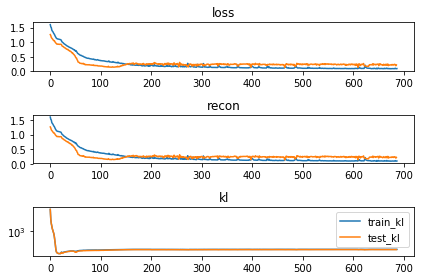

In [86]:
fig, axs = plt.subplots(ncols=1, nrows=train_reports.shape[1], sharey=False)
for a, n, ax in zip(range(train_reports.shape[1]), _recorded_scalars_, axs):
    #plt.subplot(train_reports.shape[1], 1, a + 1)
    if 'kl' in n:
        ax.semilogy(train_reports[:, a], label=f"train_{n}")
        ax.semilogy(test_reports[:, a], label=f"test_{n}")
    else:
        ax.plot(train_reports[:, a], label=f"train_{n}")
        ax.plot(test_reports[:, a], label=f"test_{n}")
    ax.set_title(n)
    
plt.tight_layout()
plt.legend()

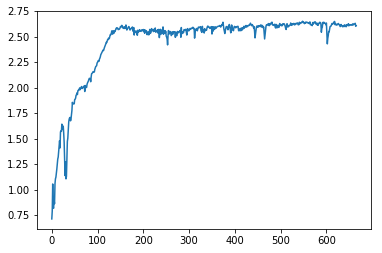

In [87]:
plt.plot(test_reports[20:, -1])

In [61]:
#plots.plot_losses(train_losses, test_losses, exp_desc=exp_desc);

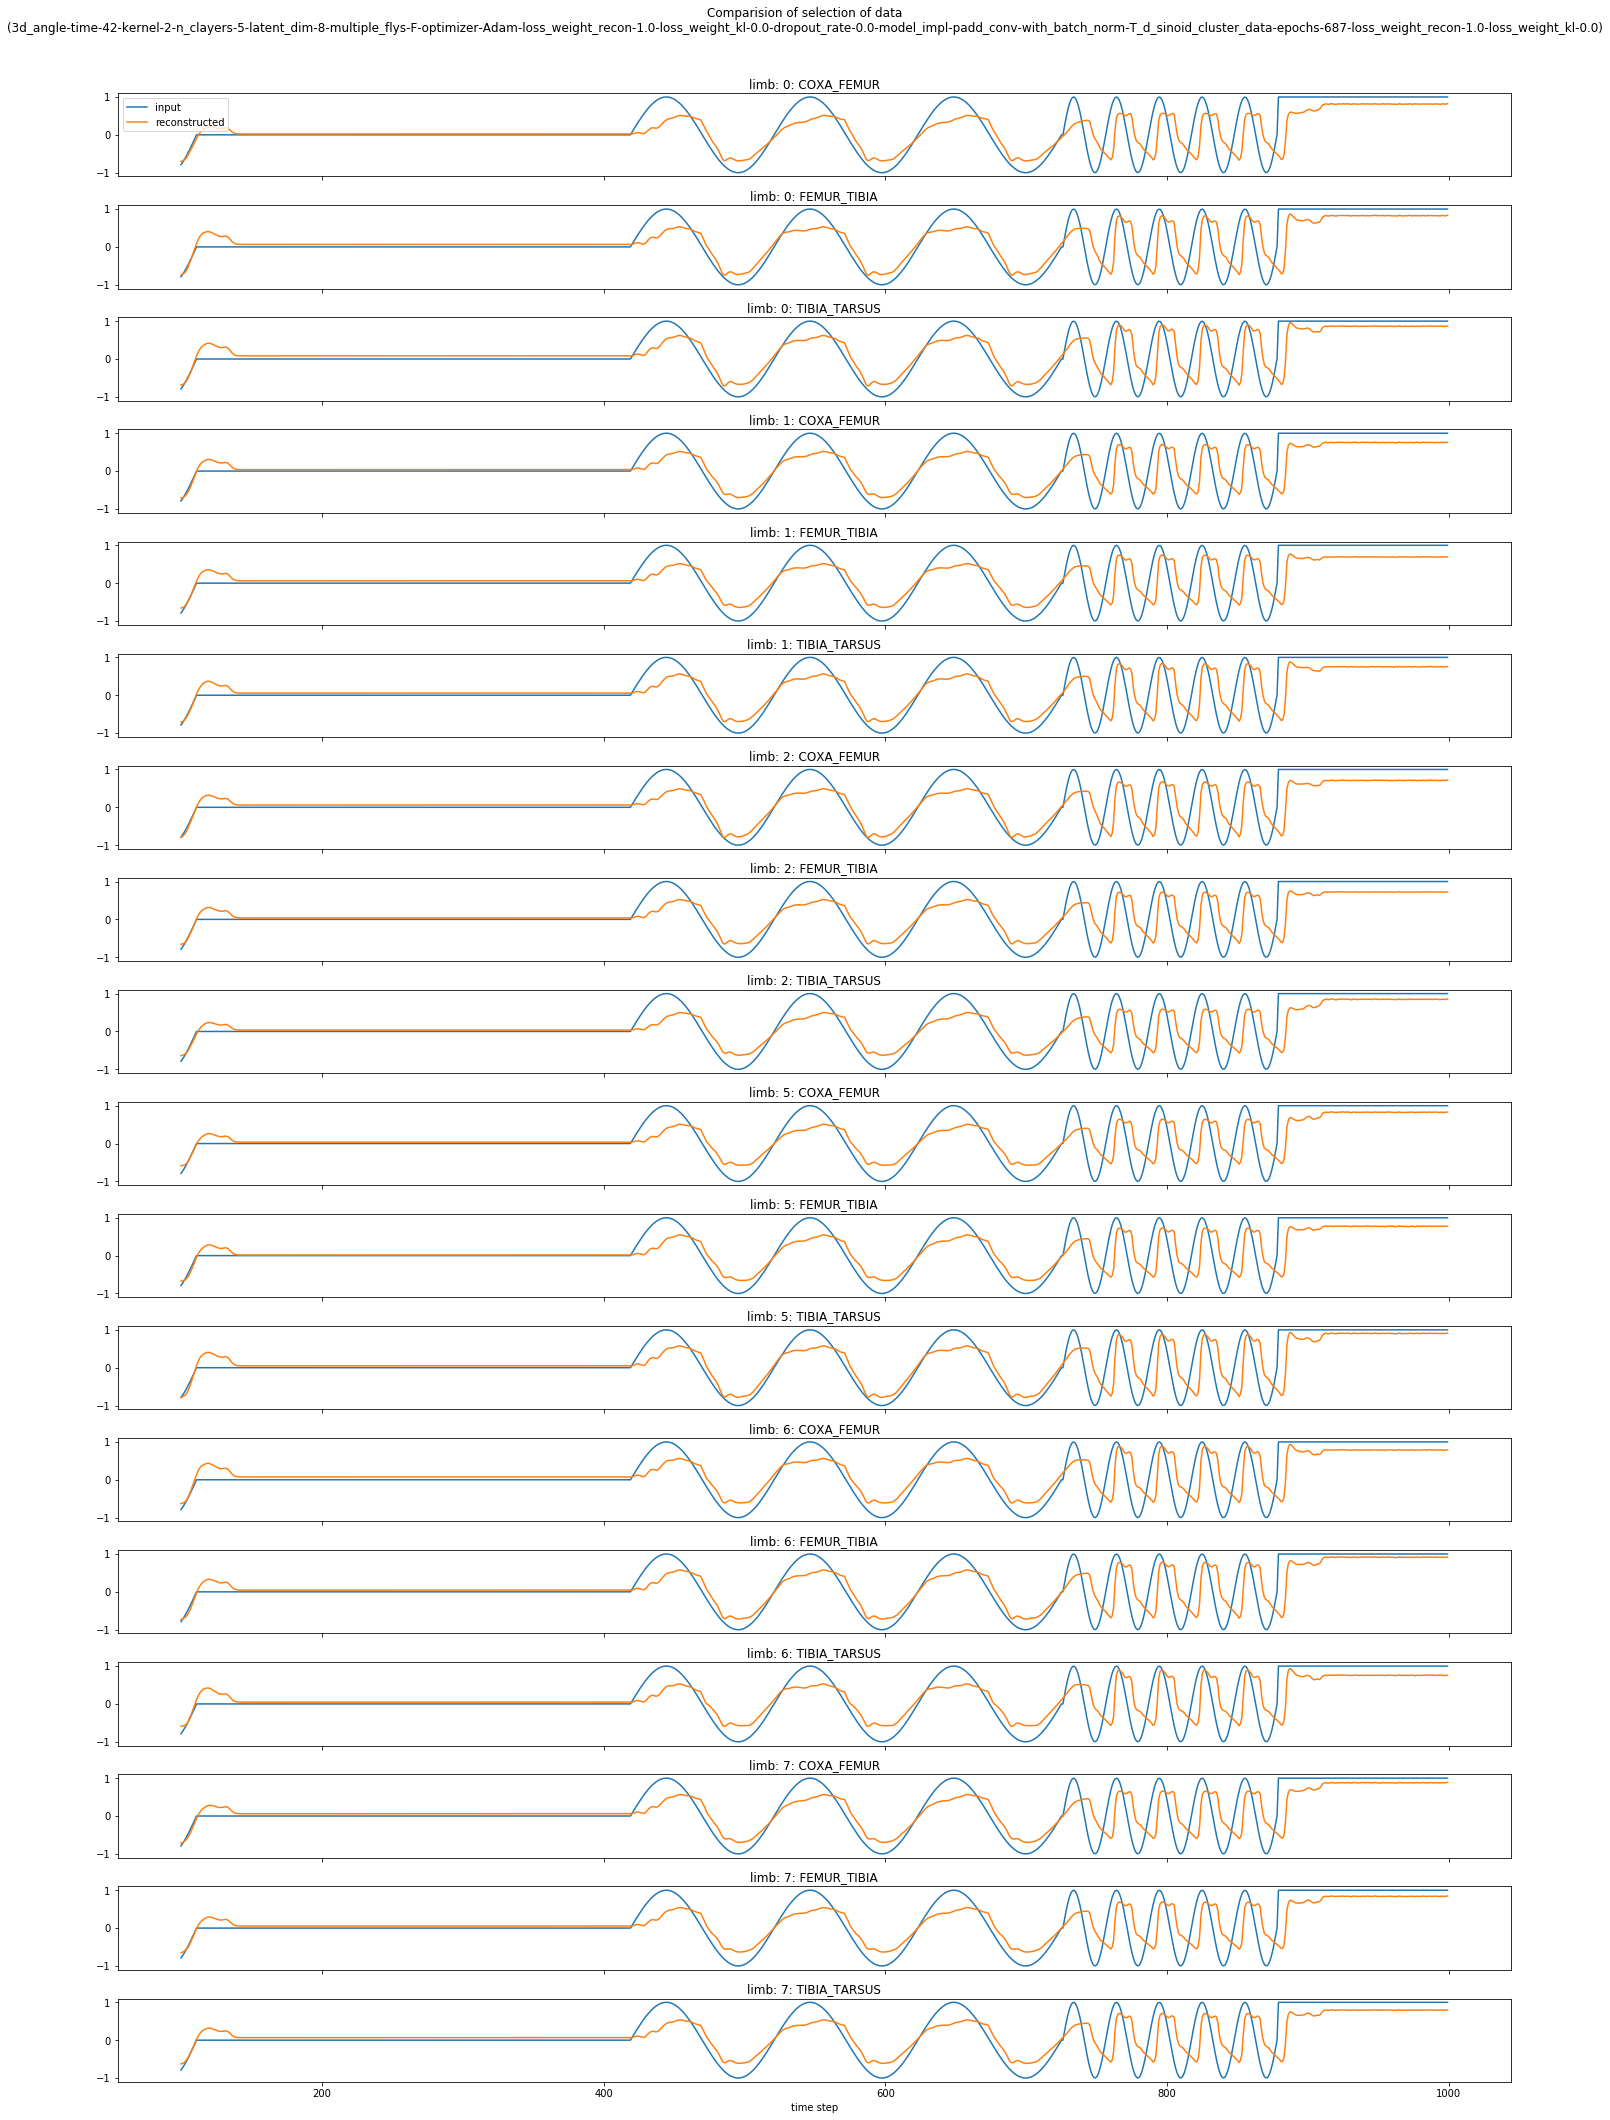

In [88]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    fig = plots.plot_comparing_joint_position_with_reconstructed(input_data, reconstructed_data, generated_data, validation_cut_off=len(data_train), exp_desc=exp_desc);
else:
    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
    fig, axs = plt.subplots(nrows=input_data.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
    start = 100
    end = 1000
    xticks = np.arange(start, end)
    for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
        _idx_ = np.s_[start:end, i]
        axs[i].plot(xticks, input_data[_idx_], label='input')
        axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
        #axs[i].plot(xticks, generated_data[_idx_], label='generated')
        
        axs[i].set_title(cn)
        
        #for a in axs[i]:
        #    a.axvline(len(data_train), label='validation cut off', linestyle='--')

    axs[-1].set_xlabel('time step')
    axs[0].legend(loc='upper left')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [79]:
from hdbscan import HDBSCAN

In [80]:
from collections import namedtuple
from sklearn.manifold import TSNE

LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

if run_config['use_all_experiments']:
    warnings.warn('should use all data `input_data`')
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw[np.random.choice(len(input_data), 10000)])))
    else:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(input_data_raw[np.random.choice(len(input_data), 10000)])))
else:
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw)))
    else:
        X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(input_data_raw)))
    
X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

In [81]:
cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

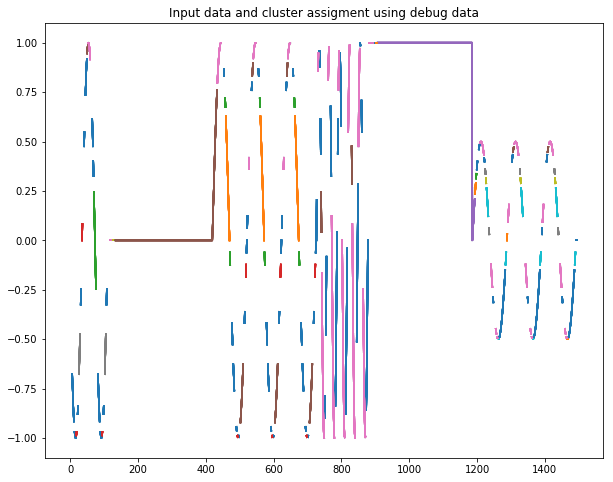

In [82]:
def plot_debug(input_data, cluster_assignments, cluster_colors=None):
    _clusters = np.unique(cluster_assignments)
    _colors = sns.color_palette(n_colors=len(_clusters))
    if cluster_colors is None:
        cluster_colors = dict(zip(_clusters, _colors))

    plt.figure(figsize=(10, 8))
    for cluster_id, segments in video.group_by_cluster(cluster_assignments).items():
        for s in segments:
            plt.plot(s, input_data[s], c=cluster_colors[cluster_id])

    plt.title('Input data and cluster assigment using debug data');
    
if run_config['debug']:
    plot_debug(input_data, cluster_assignments)

In [83]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

In [84]:
exp_desc_short

'3d_angle-t-42-k-2-ncl-5-ld-8-mf-F-opt-Adam-lwr-1.0-lwkl-0.0-dr-0.0-mi-padd_conv-bn-T_d_sinoid_cluster_data-e-687-lwr-1.0-lwkl-0.0'

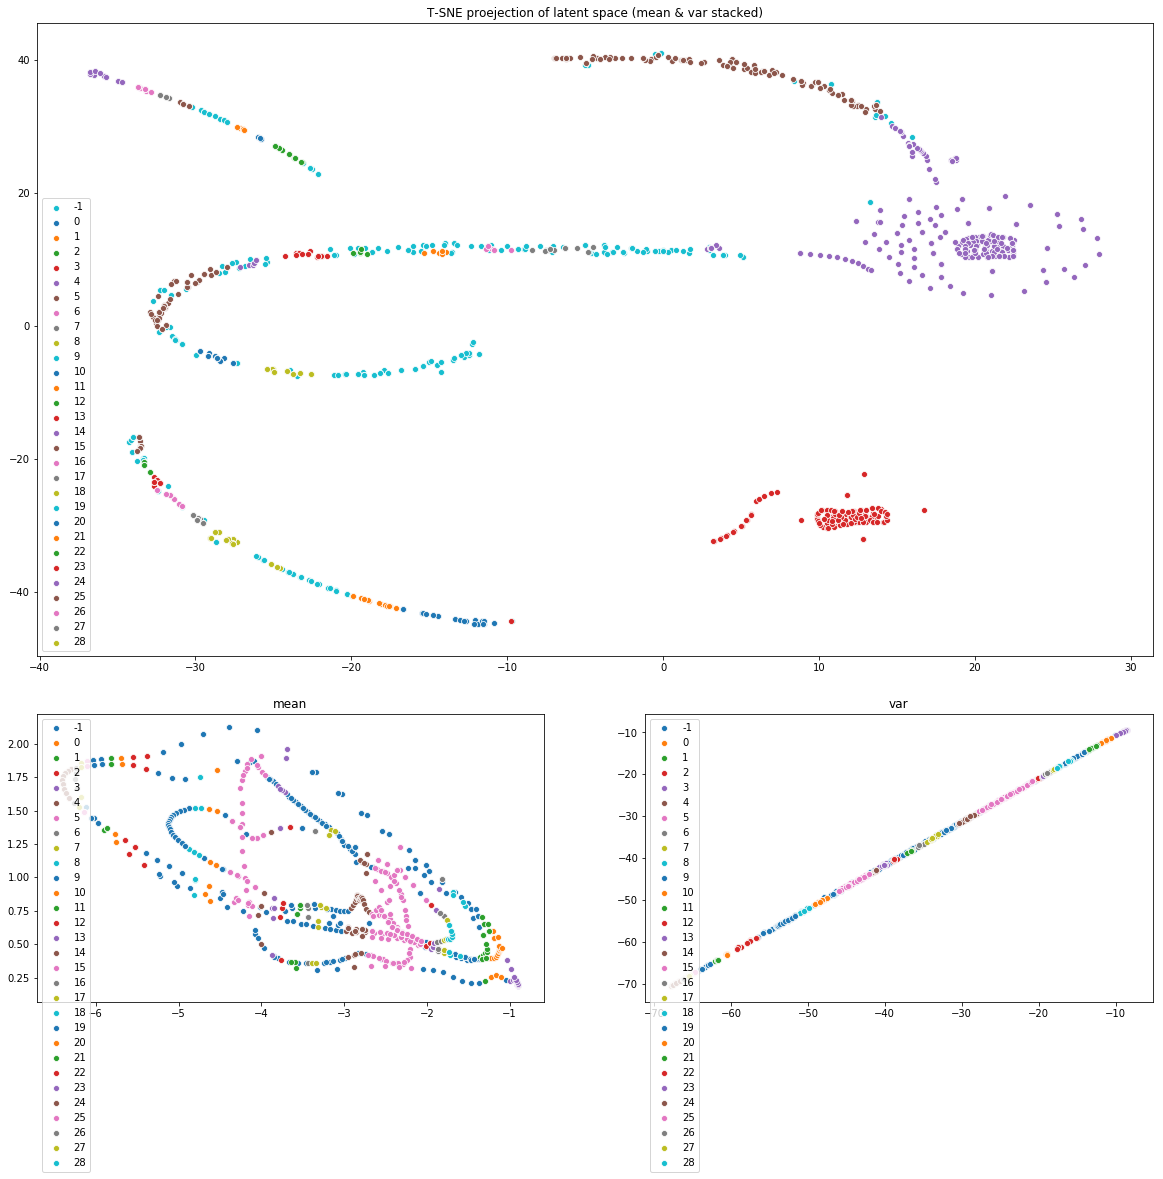

In [85]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[-1:, :1])
ax3 = plt.subplot(gs[-1:, 1:])

#plt.figure(figsize=(20, 12))
#fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))
for cluster in np.unique(cluster_assignments):
    c_idx = cluster_assignments == cluster
    if run_config['use_all_experiments']:
        c_idx = c_idx & (np.random.random(len(c_idx)) > 0.7) # don't show all of them, takes for ever otherwise
    sns.scatterplot(X_latent_mean_tsne_proj[c_idx, 0], X_latent_mean_tsne_proj[c_idx, 1], label=cluster, ax=ax1, color=cluster_colors[cluster])
    sns.scatterplot(X_latent.mean[c_idx, 0], X_latent.mean[c_idx, 1], label=cluster, ax=ax2)
    sns.scatterplot(X_latent.var[c_idx, 0], X_latent.var[c_idx, 1], label=cluster, ax=ax3)
    
plt.legend()
ax1.set_title('T-SNE proejection of latent space (mean & var stacked)')
ax2.set_title('mean')
ax3.set_title('var');

In [44]:
stop

NameError: name 'stop' is not defined

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()